# **Extract Rasters to Validation Pixels**

This is a script that Paul asked for to take in points from a .CSV file, for each point loop through a tiled raster GPKG to identify tiled raster over point, and loop through rasters to extract point to data table. 
Workflow is suspected to be something like this.
1) Identify raster data and run footprint to return a geopackage file.
2) Intersect input points with this footprint to get path to raster intersecting points
3) Loop through tiles that coincide with points of interest, extract values over points, append to data table containing all points. 

Step 1 may be executed outside of this notebook as Paul may just run a previous geopackage code.

#Notes as of 20220726:
- May want to create a separate gdf that just stores raster paths. Can likely be linked by index value in the point gdf.
- May need to implement multiband support. This would work well if all tiled rasters are in the same tiling scheme. A VRT could be created for each tile of all rasters wanted.
- Minor changes may need to be made to column names to work with Elizabeth's point file

In [2]:
!pip install -U rasterstats

  Using cached simplejson-3.17.6-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (130 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from pathlib import Path
import geopandas as gpd
import numpy as np
from geopandas import GeoDataFrame
from geopandas.tools import sjoin
import pandas as pd
import pyproj
import shapely

import glob
import os
import random 
import shutil
import time

import rasterio as rio
from rasterio.coords import BoundingBox
from rasterio.coords import disjoint_bounds

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import multiprocessing as mp
import contextily as ctx

import rasterstats
from rasterstats import point_query

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Path and info on point dataset.

    Will likely be a csv/excel file with list of points in lat/long.
    Notebook has not been tested for using Shapefile here as of 06152022
    
    

There are 401 points with 14 columns in the input.



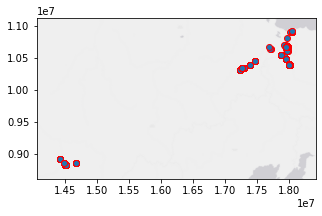

In [3]:
# CSV file with objects/points of interest. Data will append to this file
in_csv='/gpfsm/ccds01/nobackup/people/wcwagne1/TCC_validation/eurasia_forest_structure_plots_smrytrees.csv'
in_csv = '/projects/my-public-bucket/KolymaRegion_all.csv'#'/efs/pmontesa/code/3dsi/KolymaRegion_all.csv'

input_points = gpd.read_file(in_csv)
input_points_gdf = gpd.GeoDataFrame(input_points, geometry = gpd.points_from_xy(input_points.lon, input_points.lat))

input_points_gdf.crs="epsg:4326"
rows,columns = input_points_gdf.shape

print("There are {} points with {} columns in the input.\n".format(rows, columns))

if False:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ##Change for better representation of world map(Set for Siberia now)
    ax = world.cx[-180:180, 40:90].to_crs(3995).plot(color='white',edgecolor='black')
    print("Input point locations")
    ax = input_points_gdf.to_crs(3995).plot(ax=ax, color='red')

if True:
    ax = input_points_gdf.to_crs(3857).plot(figsize=(5, 5), edgecolor='red')
    plt.margins(y=0.1, x=0.1)
    ctx.add_basemap(ax,  source="http://services.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}")

## **Input the raster tile footprints
Raster Geopackage Information if working with Tiled Rasters

Raster tile footprints


,footprint_name,path,file,area_km2,area_ha,tile_num,s3_path,geometry
0,h1000v084,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1000v084_y2020_dat.tif,577.4409,57744.09,0,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,"POLYGON ((4008920.644 7967524.678, 4008920.644..."
1,h1000v086,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1000v086_y2020_dat.tif,577.4409,57744.09,1,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,"POLYGON ((4008920.644 7919524.678, 4008920.644..."
2,h1000v087,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1000v087_y2020_dat.tif,577.4409,57744.09,2,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,"POLYGON ((4008920.644 7895524.678, 4008920.644..."
3,h1000v092,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1000v092_y2020_dat.tif,577.4409,57744.09,3,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,"POLYGON ((4008920.644 7775524.678, 4008920.644..."
4,h1000v093,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1000v093_y2020_dat.tif,577.4409,57744.09,4,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,"POLYGON ((4008920.644 7751524.678, 4008920.644..."


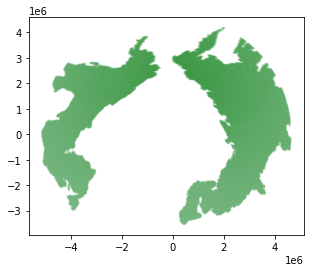

In [4]:
#Raster tile/geopackage with attribute pointing to raster files. These values will be extracted over each point in CSV
footprint_fn='/adapt/nobackup/people/pmontesa/userfs02/data/standage/Boreal_stand_age_v3/Boreal_v3_index.geojson'
footprint_fn = '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_boreal-tcc-unclipped-2020.gpkg'
footprint_gdf = gpd.read_file(footprint_fn)
print("Raster tile footprints")
footprint_gdf.to_crs(3995).plot(edgecolor ='green', alpha=0.1, color=None)
footprint_gdf.head()

## **This section will need to be edited to suit the Rasters that are being used.
    You may need to add new parameters to the raster dictionary based on the rasters being used

In [5]:
dict_list = [
#     {'location':'local', #'local' or 's3'
#      'data_dir': "/adapt/nobackup/people/pmontesa/userfs02/data/worldclim/1km/bioclim/wc2.0_30s_bio/",
#      'file_name': "wc2.0_bio_30s_18.tif",
#      'multi_band': False,
#      'is_tiled': False, #determines if a point by point extraction is needed
#      's3_url_prefix': None,
#      'data_source': 'worldclim-adapt',
#      'data_name': 'Worldclim18', # The column name in the point gdf for the raster values. 
#      'aws_credential_fn': None
#     },  
#     # TerraPulse Stand Age tiles
#     {'location':'local',  #'local' or 's3'
#      'data_dir': "/adapt/nobackup/people/pmontesa/userfs02/data/standage/Boreal_stand_age_v3",
#      'file_name': None, # filename will be a combination of the "data_dir" parameter and "location" value in the raster gdf if using relative paths.
#      'multi_band': False,
#      'is_tiled': True,
#      's3_url_prefix': None,
#      'data_source': 'terrapulse-adapt',
#      'data_name': 'terrapulse_standage',
#      'aws_credential_fn': None
#     },
]

dict_tcc = { 
        # TerraPulse unclipped annual boreal TCC
     'location':'s3',  #'local' or 's3'
     'data_dir': None,
     'file_name': None, # filename will be a combination of the "data_dir" parameter and "location" value in the raster gdf if using relative paths.
     'multi_band': False,
     'is_tiled': True,
     'footprint_fn' : '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_boreal-tcc-unclipped-2020.gpkg',
     's3_url_prefix': None,
     'data_source': 'terrapulse-adapt',
     'data_name': 'tp_tcc2020',
     'aws_credential_fn': '/efs/pmontesa/credentials'
    }

## **Functions used to perform the Extraction
    Multiband support has not been implemented. Separate location gdf has also not been implemented

In [6]:
# sampling rasters with atl_subset points
#coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]
#gdf[list(src.descriptions)] = [x for x in src.sample(coord_list)]
#gdf[list(src2.descriptions)] = [x for x in src2.sample(coord_list)]

def do_s3_point_query(s3_url, gdf, raster_data_name, ANON=True, PROFILE_NAME='boreal_pub'):
    import rasterio
    if ANON:
        session = rasterio.env.Env(AWS_NO_SIGN_REQUEST='YES')
    else:
        session = rasterio.env.Env(profile_name=PROFILE_NAME)
    with session:
        with rasterio.open(s3_url, mode='r') as dataset:
            
            new_gdf = reproject_gdf_to_rio_ds(gdf, dataset)
            coord_list = [(x,y) for x,y in zip(new_gdf['geometry'].x , new_gdf['geometry'].y)]
            new_gdf[raster_data_name] = [x for x in dataset.sample(coord_list)][0]
            
            return new_gdf

# def rio_open_aws_r(session, url, gdf):
#     with session:
#         with rio.open(url) as ras:
#             new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
#             new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) 
#             return new_gdf

def do_point_query(new_gdf, ras_fn):
    return point_query(new_gdf,ras_fn, interpolate='nearest')

def get_transformation(ras_fn, gdf):
    ras=rio.open(ras_fn)
    ras_crs=ras.crs
    ras.close()
    return pyproj.Transformer.from_crs(gdf.crs, ras_crs, always_xy=True).transform

def reproject_gdf_to_rio_ds(gdf, rio_ds):
        ras_crs=rio_ds.crs
        gdf_crs=gdf.crs
        return gdf.to_crs(ras_crs)

def clip_and_join(gdf,ras_gdf):
    """
    When working with the tiled raster this function is called to remove the raster tiles from the raster_gdf that don't overlap the points. 
    The Raster paths are then joined with the (point) gdf to get the raster tile path corresponding to each point.
    All functions assume raster path info is stored in column named "location"
    """
    overlaps=gpd.clip(ras_gdf, gdf,keep_geom_type=True)
    gdf=gpd.sjoin(gdf,overlaps, how="left")
    gdf.sindex
    overlaps=None
    has_joined=True
    return gdf,has_joined

def ExtractUntiledRaster(gdf,ras_dict):
    """For untiled rasters, the gdf just needs to be reprojected to the raster projection, then the point_query function takes in 
    the reprojected gdf and the path to the global raster (eg. Worldclim files)"""
    
    if ras_dict['location'] == 'local':
        print("Raster is an ADAPT untiled raster")
        #Open Raster from local source
        ras_fn=os.path.join(ras_dict['data_dir'],ras_dict['file_name'])
        ras=rio.open(ras_fn)
        new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
        new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) #Main command to extract ras values. For untiled takes reprojected df and global raster path
        return new_gdf

        
    elif ras_dict['location'] == 's3':
        print("Raster is an S3 untiled raster")
        session = rasterio.env.Env(profile_name='')
        url = os.path.join(ras_dict['data_dir'],ras_dict['file_name'])
        with session:
            with rio.open(url) as ras:
                new_gdf = reproject_gdf_to_rio_ds(gdf, ras)
                new_gdf[ras_dict['data_name']] = do_point_query(new_gdf, ras_fn) 
                return new_gdf
        
def ExtractTiledRaster(gdf,ras_dict, tcc_year=None):
    """ For the tiled rasters, the point_query function must work on a point by point basis based on the column in the gdf pointing to the
    raster location. Each point is reprojected to the specific raster underneath it, and point_query takes in the reprojected point geom
    and the path to the raster tile"""
    if ras_dict['location'] == 'local':
        print("Raster is an ADAPT tiled raster")
        n=0
        nnan=0
        value_list=[]
        for idx,point in gdf.iterrows():
            n+=1
            if type(point.location) is float:
                value_list.append(np.nan)
                nnan+=1
            else:
                ras_fn=os.path.join(ras_dict['data_dir'],str(point.location))

                new_point_geom=shapely.ops.transform(get_transformation(ras_fn, gdf), point.geometry)
                value = do_point_query(new_point_geom, ras_fn) #Main command to extract ras value. For tiled raster works point by point. Takes reprojected point geom and raster path
                value_list.append(value)
            
        gdf[ras_dict['data_name']]=value_list
        print("There were {} NaN filenames out of {}".format(nnan,n))
        
    elif ras_dict['location'] == 's3':
        #print("Raster is an S3 tiled raster")
        new_gdf_list = []
        for idx,point in gdf.iterrows(): 
            ras_fn = point.s3_path
            col_name = ras_dict['data_name']
            
            if tcc_year is not None:
                ras_fn = ras_fn.replace('y2020', 'y'+str(tcc_year))
                col_name = ras_dict['data_name'].replace('tcc2020', 'tcc'+str(tcc_year))
                
            new_gdf = do_s3_point_query(ras_fn, gdf.iloc[[idx]], col_name, ANON=True)
            new_gdf_list.append(new_gdf)
        gdf = pd.concat(new_gdf_list)
    
    return gdf


## **Running the extraction over the Raster Dictionary List
    Loops over the Raster Dictionaries in the list. Runs either the tiled extraction or untiled extraction based on the "is_tiled" parameter in the dictionary. 

In [7]:
def run_extract_tiled_tcc_year(input_points_gdf, raster_dict=None, tcc_year=None, has_joined=False):
    
    '''
    Function formulated to extract yearly TCC raster values on s3 to points in a geodataframe
    
    ras_dict : a dictionary of tcc2020 raster location, name, and raster footprint gpkg path
    input_points_gdf : a geodataframe with geometry that will be reprojected to that of raster tile using the raster footprint geodataframe
    has_joined : if True then no clipping
    
    note : this function can be multithreaded like this:
    from multiprocessing import Pool
    from functools import partial

    with Pool(processes=10) as pool:
        pool.map(partial(run_extract_tiled_raster, raster_dict=<a_dict>, tcc_year=<a_year>), input_points_gdf_list)
    '''
    if raster_dict is None:
        print('Input raster dict is None.')
        return None
    
    #print("\nRunning point extraction for tiled tcc raster for year {}".format(str(tcc_year)))
    if has_joined:
        pass
    else:
        #print("\n\tClipping to get tiles overlapping points and spatially joining with footprint tile extent to get tile path...")
        footprint_gdf = gpd.read_file(raster_dict['footprint_fn'])
        joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)

    extracted_points_gdf = ExtractTiledRaster(joined_points_gdf, raster_dict, tcc_year=tcc_year)
    
    return extracted_points_gdf

## Use dictionary for TCC2020 to get yearly TCC values

##### Define multiprocessing function

In [8]:
from multiprocessing import Pool
from functools import partial
    
def multiprocess_extract(tcc_year, dict_tcc, input_points_gdf_list):

    extracted_points_gdf_list = []
    print(f'Extracting TCC from {tcc_year}...')
    with Pool(processes=10) as pool:
        gdf = pool.map(partial(run_extract_tiled_tcc_year, raster_dict = dict_tcc, tcc_year = tcc_year), input_points_gdf_list)
        return gdf

### Where the magic happens
still somewhat slow method: loop over all TCC time series years, multiprocessing in chunks of input points gdf

In [9]:
orig_cols_list = list(input_points_gdf.columns)
#orig_cols_list.remove('index1')
print(orig_cols_list)

['site', 'lat', 'lon', 'canopy_cover', 'canopy_ste', 'stand_density', 'density_ste', 'larch_biomass', 'biomass_ste', 'year', 'area_sampled', 'project', 'plot', 'geometry']


In [10]:
%%time

n = 20  #chunk row size
tcc_years_list = list(range(1984, 2021))
orig_cols = input_points_gdf.columns
input_points_gdf['index1'] = input_points_gdf.index

extracted_points_gdf = input_points_gdf#.sample(frac=0.1)

# This concats the data for a given year (which is chunked for multiprocessing), then builds a list of all the concat'd yearly gdfs
# This list needs to be merged to return 1 gdf with yearly cols of tcc for each point
extracted_points_gdf_list_4_merge = [pd.concat(multiprocess_extract(tcc_year, dict_tcc, [extracted_points_gdf[i:i+n].reset_index() for i in range(0, extracted_points_gdf.shape[0],n)] ) ) for tcc_year in tcc_years_list] 


Extracting TCC from 1984...
Extracting TCC from 1985...
Extracting TCC from 1986...
Extracting TCC from 1987...
Extracting TCC from 1988...
Extracting TCC from 1989...
Extracting TCC from 1990...
Extracting TCC from 1991...
Extracting TCC from 1992...
Extracting TCC from 1993...
Extracting TCC from 1994...
Extracting TCC from 1995...
Extracting TCC from 1996...
Extracting TCC from 1997...
Extracting TCC from 1998...
Extracting TCC from 1999...
Extracting TCC from 2000...
Extracting TCC from 2001...
Extracting TCC from 2002...
Extracting TCC from 2003...
Extracting TCC from 2004...
Extracting TCC from 2005...
Extracting TCC from 2006...
Extracting TCC from 2007...
Extracting TCC from 2008...
Extracting TCC from 2009...
Extracting TCC from 2010...
Extracting TCC from 2011...
Extracting TCC from 2012...
Extracting TCC from 2013...
Extracting TCC from 2014...
Extracting TCC from 2015...
Extracting TCC from 2016...
Extracting TCC from 2017...
Extracting TCC from 2018...
Extracting TCC from 

In [1]:
final_extracted_points_gdf_list_4_merge[10].head()

NameError: name 'final_extracted_points_gdf_list_4_merge' is not defined

#### Post-process out gdf list

In [15]:
# Drop redundant cols
final_extracted_points_gdf_list_4_merge = [gdf[['index1'] + [col for col in gdf.columns if 'tp_tcc' in col]] for gdf in extracted_points_gdf_list_4_merge]

### -- FIND ALTERNATE - MEMORY OVERLOAD

In [ ]:
%%time

# Merge single year gdfs into 1 multi-year gdf

from functools import reduce
multi_year_gdf = reduce(lambda x, y: pd.merge(x, y, on='index1'), final_extracted_points_gdf_list_4_merge)

# Drop all the duplicate cols from the mer
#multi_year_gdf = multi_year_gdf[['index1'] + [col for col in multi_year_gdf.columns if 'tp_tcc' in col]]
multi_year_gdf.shape
multi_year_gdf.head()

In [ ]:
extracted_points_gdf_list_4_merge[0]

In [ ]:
extracted_points_gdf = input_points_gdf

#has_joined = False
for tcc_year in tcc_years_list:
    
    print(tcc_year)
    extracted_points_gdf = run_extract_tiled_tcc_year(extracted_points_gdf, raster_dict=dict_tcc, tcc_year=tcc_year, has_joined=False)
    #has_joined = True
    
    # These are dropped - they are joined from the footprints gdf
    extracted_points_gdf.drop(['index_right', 'footprint_name', 'path', 'file', 'area_km2', 'area_ha', 'tile_num', 's3_path'], axis=1, inplace=True)


1984

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1985

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1986

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1987

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1988

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1989

Running Point Extraction for Tiled Raster tp_tcc2020

	Clipping out Raster tiles not overlapping points Shapefile and Joining
Raster is an S3 tiled raster
1990

Running Point Extraction for

In [ ]:
extracted_points_gdf.shape

In [135]:
extracted_points_gdf.shape

(405, 23)

In [ ]:
has_joined=False #Only need to run once, assuming only 1 raster geopackage is needed. Notebook was written with that assumption
tcc_years_list = list(range(1984, 2021))

#Looping through Rasters First;Wont matter for testing
for ras_dict in dict_list:
    
    if not ras_dict['is_tiled']:
        print("\nRunning Point Extraction for {}".format(ras_dict['data_name']))
        extracted_points_gdf = ExtractUntiledRaster(input_points_gdf, ras_dict)
    else:
        #         print("\nRunning Point Extraction for Tiled Raster {}".format(ras_dict['data_name']))
        #         if has_joined:
        #             pass
        #         else:
        #             print("\n\tClipping out Raster tiles not overlapping points Shapefile and Joining")
        #             footprint_gdf = gpd.read_file(ras_dict['footprint_fn'])
        #             joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)

        #         extracted_points_gdf = ExtractTiledRaster(joined_points_gdf, ras_dict, tcc_year=None)

        extracted_points_gdf = run_extract_tiled_tcc_year(input_points_gdf, raster_dict=ras_dict, tcc_year=2019, has_joined=False)
        
    print("\nFinished running Extraction for {}".format(ras_dict['data_name']))

extracted_points_gdf.head() 

In [75]:
joined_points_gdf, has_joined = clip_and_join(input_points_gdf.to_crs(footprint_gdf.crs), footprint_gdf)
#extracted_points_gdf = ExtractTiledRaster(joined_points_gdf, ras_dict)

g1 = do_s3_point_query( 's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1104/v098/h1104v098/h1104v098_y2020_dat.tif', joined_points_gdf, 'tp_tcc2020', ANON=True, PROFILE_NAME='boreal_pub')
g2 = do_s3_point_query( 's3://terrapulse-pub-data/boreal-tcc-unclipped/data/h1104/v098/h1104v098/h1104v098_y2020_dat.tif', joined_points_gdf, 'tp_tcc2020', ANON=True, PROFILE_NAME='boreal_pub')
g = pd.concat([g1,g2])
g

[array([14], dtype=uint8), array([22], dtype=uint8), array([8], dtype=uint8), array([5], dtype=uint8), array([255.])]
[array([14], dtype=uint8), array([22], dtype=uint8), array([8], dtype=uint8), array([5], dtype=uint8), array([255.])]


,site,lat,lon,canopy_cover,canopy_ste,stand_density,density_ste,larch_biomass,biomass_ste,year,...,geometry,index_right,footprint_name,path,file,area_km2,area_ha,tile_num,s3_path,tp_tcc2020
0,1,68.76231,161.23608,15.51,1,0.05,0.03,611.2,431.5,2010,...,POINT (6494436.074 7646028.634),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[14]
1,2,68.76919,161.24397,7.52,0.6,0,0,0,0,2010,...,POINT (6492747.091 7646793.656),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[22]
2,3,68.78801,161.49601,7.86,1.6,0.02,0.02,0.3,0.3,2010,...,POINT (6497397.338 7648886.347),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[8]
3,4,68.7822,161.47642,2.91,0.87,0.01,0.01,0,0,2010,...,POINT (6498306.530 7648240.304),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[5]
4,5,68.7457,161.53402,0.74,0.39,0,0,0,0,2010,...,POINT (6511290.010 7644181.685),8427,h1105v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1105v098_y2020_dat.tif,577.4409,57744.09,3427,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[255.0]
0,1,68.76231,161.23608,15.51,1,0.05,0.03,611.2,431.5,2010,...,POINT (6494436.074 7646028.634),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[14]
1,2,68.76919,161.24397,7.52,0.6,0,0,0,0,2010,...,POINT (6492747.091 7646793.656),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[22]
2,3,68.78801,161.49601,7.86,1.6,0.02,0.02,0.3,0.3,2010,...,POINT (6497397.338 7648886.347),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[8]
3,4,68.7822,161.47642,2.91,0.87,0.01,0.01,0,0,2010,...,POINT (6498306.530 7648240.304),8338,h1104v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1104v098_y2020_dat.tif,577.4409,57744.09,3338,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[5]
4,5,68.7457,161.53402,0.74,0.39,0,0,0,0,2010,...,POINT (6511290.010 7644181.685),8427,h1105v098,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,h1105v098_y2020_dat.tif,577.4409,57744.09,3427,s3://terrapulse-pub-data/boreal-tcc-unclipped/...,[255.0]


This next section contains a function provided by Paul from Laura Duncansons github, in dealing with icesat2. Looks to extract raster band values to the obs of a geodataframe. 
## **Function to extract values to geodataframe obj**

In [57]:
def extract_value_gdf(r_fn, pt_gdf, bandnames: list, reproject=True, TEST=False):
    """Extract raster band values to the obs of a geodataframe
    """

    print("\tExtracting raster values from: ", r_fn)
    r_src = rio.open(r_fn)
    
    if reproject:
        print("\tRe-project points to match raster...")
        pt_gdf = pt_gdf.to_crs(r_src.crs)
    
    for idx, bandname in enumerate(bandnames):
        bandnum = idx + 1
        if TEST: print("Read as a numpy masked array...")
        r = r_src.read(bandnum, masked=True)
        
        if TEST: print(r.dtype)

        pt_coord = [(pt.x, pt.y) for pt in pt_gdf.geometry]

        # Use 'sample' from rasterio
        if TEST: print("Create a generator for sampling raster...")
        pt_sample = r_src.sample(pt_coord, bandnum)
        
        if TEST:
            for i, val in enumerate(r_src.sample(pt_coord, bandnum)):
                print("point {} value: {}".format(i, val))
            
        if TEST: print("Use generator to evaluate (sample)...")
        pt_sample_eval = np.fromiter(pt_sample, dtype=r.dtype)

        if TEST: print("Deal with no data...")
        pt_sample_eval_ma = np.ma.masked_equal(pt_sample_eval, r_src.nodata)
        #pt_gdf[bandname] = pd.Categorical(pt_sample_eval_ma.astype(int).filled(-1))
        pt_gdf[bandname] = pt_sample_eval_ma.astype(float).filled(np.nan)
        
        #print('\tDataframe has new raster value column: {}'.format(bandname))
        r = None
        
    r_src.close()
    
    print('\tReturning {} points with {} new raster value columns: {}'.format(len(pt_gdf), len(bandnames), bandnames))
    return(pt_gdf)
